In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
class PreprocessingLayer(torch.nn.Module):
    def forward(self, inputs: torch.Tensor):
        min_val = inputs.min(axis=0).values
        max_val = inputs.max(axis=0).values
        normalized_inputs = torch.where(
            (max_val - min_val) != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            torch.zeros_like(inputs)
        )
        return normalized_inputs

In [32]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        super().__init__()
        self.l2_lambda = torch.tensor(l2_lambda)
        self.prep_layer = PreprocessingLayer()
        self.encoder1 = torch.nn.Linear(input_shape[0], 18)
        self.encoder1_activation = torch.nn.ReLU()
        self.encoder2 = torch.nn.Linear(18, 8)
        self.encoder2_activation = torch.nn.Sigmoid()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 18),
            torch.nn.Sigmoid(),
            torch.nn.Linear(18, input_shape[0]),
            torch.nn.Sigmoid()
        )
        self.mse_loss = torch.nn.MSELoss(reduction='none')

    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        l2_activity_loss = self.l2_lambda * torch.sum(encoded ** 2)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        mse = self.mse_loss(prep, decoded)
        avg_mse_per_input = torch.mean(mse, dim=1)
        return decoded, avg_mse_per_input, l2_activity_loss
    
    def fit(self, inputs: np.ndarray, batch_size: int, epochs: int, optimizer, criterion):
        inputs = torch.tensor(inputs.astype(np.float32))
        targets = PreprocessingLayer()(inputs)
        batched_data = DataLoader(targets, batch_size=batch_size, shuffle=True)
        batch_steps = len(batched_data)
        training_loss = []

        for epoch in range(epochs):
            self.train()
            epoch_decoder_losses = []
            epoch_total_losses = []
            for idx, batch in enumerate(batched_data):
                # Forward pass
                decoded, _, l2_loss = self(batch)
                loss = criterion(batch, decoded)
                loss_value = loss.item()
                epoch_decoder_losses.append(loss_value)

                # Compute total loss
                total_loss = loss + l2_loss
                total_loss_value = total_loss.item()  # This slows down the code if using GPU, since we convert this value from CUDA to a python float
                epoch_total_losses.append(total_loss_value)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                print(f"Epoch [{epoch + 1}/{epochs}], Step [{idx + 1}/{batch_steps}], decoder loss: {loss_value:.4f}, encoder1_activation l2 loss: {l2_loss:.4f}, total loss: {total_loss_value:.4f}")

            epoch_decoder_avg_loss = np.array(epoch_decoder_losses).mean()
            epoch_total_avg_loss = np.array(epoch_total_losses).mean()
            training_loss.append(epoch_total_avg_loss)

            print(f"Epoch [{epoch + 1}/{epochs}] (avg {batch_steps} steps), decoder loss: {epoch_decoder_avg_loss:.4f}, total loss: {epoch_total_avg_loss:.4f}")
        
        return training_loss

In [33]:
train_data = np.load("data/data_386642.npy")
train_label = np.load("data/label_386642.npy")

# We want to feed the Autoencoder with GOOD data, so we filter the data by the label == 1
train_data = train_data[train_label == 1]
train_data

array([[1940., 1987.,  670., ...,    0.,    0.,    0.],
       [1869., 1872.,  714., ...,    0.,    0.,    0.],
       [1819., 1924.,  672., ...,    0.,    0.,    0.],
       ...,
       [1171.,  989.,  293., ...,    0.,    0.,    0.],
       [1225.,  960.,  289., ...,    0.,    0.,    0.],
       [1190.,  994.,  257., ...,    0.,    0.,    0.]])

In [34]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001, eps=1e-07)

In [35]:
training_loss = ae.fit(train_data, 128, 200, optimizer, criterion)

Epoch [1/200], Step [1/6], decoder loss: 0.2104, encoder1_activation l2 loss: 0.0023, total loss: 0.2127
Epoch [1/200], Step [2/6], decoder loss: 0.2088, encoder1_activation l2 loss: 0.0022, total loss: 0.2110
Epoch [1/200], Step [3/6], decoder loss: 0.2069, encoder1_activation l2 loss: 0.0018, total loss: 0.2088
Epoch [1/200], Step [4/6], decoder loss: 0.2050, encoder1_activation l2 loss: 0.0018, total loss: 0.2068
Epoch [1/200], Step [5/6], decoder loss: 0.2032, encoder1_activation l2 loss: 0.0019, total loss: 0.2051
Epoch [1/200], Step [6/6], decoder loss: 0.2020, encoder1_activation l2 loss: 0.0009, total loss: 0.2029
Epoch [1/200] (avg 6 steps), decoder loss: 0.2061, total loss: 0.2079
Epoch [2/200], Step [1/6], decoder loss: 0.1994, encoder1_activation l2 loss: 0.0015, total loss: 0.2009
Epoch [2/200], Step [2/6], decoder loss: 0.1973, encoder1_activation l2 loss: 0.0014, total loss: 0.1988
Epoch [2/200], Step [3/6], decoder loss: 0.1947, encoder1_activation l2 loss: 0.0013, tota

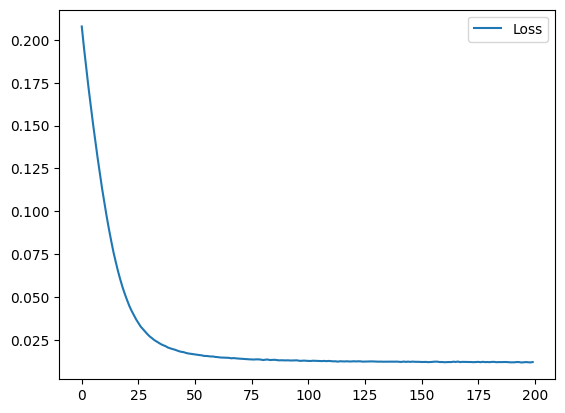

In [36]:
plt.plot(training_loss, label="Loss")
plt.legend()
plt.show()

In [45]:
ae(torch.tensor(train_data.astype(np.float32)))

(tensor([[0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224],
         [0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224],
         [0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224],
         ...,
         [0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224],
         [0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224],
         [0.7748, 0.7017, 0.5585,  ..., 0.0260, 0.0185, 0.0224]],
        grad_fn=<SigmoidBackward0>),
 tensor([0.0262, 0.0126, 0.0147, 0.0100, 0.0064, 0.0453, 0.0052, 0.0081, 0.0120,
         0.0246, 0.0139, 0.0081, 0.0299, 0.0064, 0.0035, 0.0131, 0.0389, 0.0483,
         0.0067, 0.0135, 0.0132, 0.0096, 0.0154, 0.0067, 0.0075, 0.0109, 0.0115,
         0.0081, 0.0246, 0.0062, 0.0064, 0.0056, 0.0133, 0.0081, 0.0112, 0.0061,
         0.0223, 0.0115, 0.0119, 0.0058, 0.0238, 0.0098, 0.0298, 0.0084, 0.0069,
         0.0274, 0.0127, 0.0137, 0.0119, 0.0181, 0.0080, 0.0166, 0.0028, 0.0151,
         0.0249, 0.0313, 0.0073, 0.0115, 0.0269, 0.0063, 0.0089, 0.0290,

In [46]:
class InferenceAutoencoder(Autoencoder):
    def forward(self, x):
        prep = self.prep_layer(x)
        encoded = self.encoder1(prep)
        encoded = self.encoder1_activation(encoded)
        encoded = self.encoder2(encoded)
        encoded = self.encoder2_activation(encoded)
        decoded = self.decoder(encoded)
        mse = self.mse_loss(prep, decoded)
        return torch.mean(mse, dim=1)  # Only return mse loss
    
iae = InferenceAutoencoder(input_shape=(51,), l2_lambda=1e-4)
iae.load_state_dict(ae.state_dict())
iae(torch.tensor(train_data.astype(np.float32)))

tensor([0.0262, 0.0126, 0.0147, 0.0100, 0.0064, 0.0453, 0.0052, 0.0081, 0.0120,
        0.0246, 0.0139, 0.0081, 0.0299, 0.0064, 0.0035, 0.0131, 0.0389, 0.0483,
        0.0067, 0.0135, 0.0132, 0.0096, 0.0154, 0.0067, 0.0075, 0.0109, 0.0115,
        0.0081, 0.0246, 0.0062, 0.0064, 0.0056, 0.0133, 0.0081, 0.0112, 0.0061,
        0.0223, 0.0115, 0.0119, 0.0058, 0.0238, 0.0098, 0.0298, 0.0084, 0.0069,
        0.0274, 0.0127, 0.0137, 0.0119, 0.0181, 0.0080, 0.0166, 0.0028, 0.0151,
        0.0249, 0.0313, 0.0073, 0.0115, 0.0269, 0.0063, 0.0089, 0.0290, 0.0062,
        0.0246, 0.0071, 0.0115, 0.0067, 0.0098, 0.0087, 0.0087, 0.0102, 0.0084,
        0.0155, 0.0189, 0.0167, 0.0098, 0.0143, 0.0321, 0.0104, 0.0330, 0.0152,
        0.0092, 0.0111, 0.0238, 0.0375, 0.0088, 0.0132, 0.0120, 0.0300, 0.0106,
        0.0085, 0.0093, 0.0333, 0.0230, 0.0062, 0.0067, 0.0082, 0.0066, 0.0263,
        0.0290, 0.0244, 0.0131, 0.0065, 0.0067, 0.0081, 0.0079, 0.0105, 0.0123,
        0.0096, 0.0101, 0.0059, 0.0076, 

In [ ]:
os.makedirs("./models/torch", exist_ok=True)

model_path = "./models/torch/state_dict.pth"
torch.save(ae.state_dict(), model_path)